# 薬の致死量をジスティクス回帰で調べる

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pystan
from scipy.stats import mstats
%matplotlib inline

In [2]:
plt.style.use("ggplot")

In [3]:
df = pd.read_excel("./data/dose_response.xlsx")

In [4]:
# log10 C: 薬品の投与量の対数
# death: １なら死んでる0なら生存

df.head()

,log10 C,death
0,0.95,0
1,0.94,0
2,0.95,0
3,0.96,0
4,0.99,0


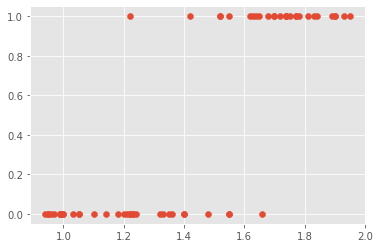

In [5]:
# 薬品の量がある閾値を超えると死亡確率急激に増加する

plt.scatter(df["log10 C"], df["death"])

In [6]:
# PyStanは書き方が特殊
# コメントで以下のようなブロックを書く必要がある
# ①dataブロック（観測したデータの入れ物）→
# ②パラメータのブロック→
#  ベルヌーイロジットののパラメータはa,bだけ
# ③統計モデルの（尤度関数）ブロック→
# ④事前分布
#  省略している。事前分布していなければ無条件兼事前分布が事前分布になる

stan_model = """
data {
  int N;
  real X[N];
  int<lower=0, upper=1> Y[N];
}

parameters {
  real a;
  real b;
}

model {
  for (n in 1:N){
    Y[n] ~ bernoulli_logit(a * X[n] + b);
  }
}

"""

In [7]:
# PyStanはコンパイルが必要（C++でコンパイルされる）
# 結構時間かかる

sm = pystan.StanModel(model_code= stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2ceeea67f566a1f79865245e63738ff6 NOW.


In [8]:
# dataブロックに入れるデータを辞書型で渡す

stan_data = {"N":df.shape[0], "X":df["log10 C"], "Y":df["death"]}

In [9]:
# MCMCでサンプリング

fit = sm.sampling(data = stan_data, iter = 2000, warmup=500, chains=3, seed=123)

In [10]:
# 結果の抽出
# 事後分布の平均値や誤差が表示される
# Rhat<=1ならうまく収束している

fit

Inference for Stan model: anon_model_2ceeea67f566a1f79865245e63738ff6.
3 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a     13.62    0.14   3.46   7.94  11.15  13.18  15.66  21.12    594    1.0
b    -20.31    0.21   5.24 -31.77 -23.53 -19.68 -16.59 -11.72    594    1.0
lp__ -14.91    0.04   1.04  -17.7 -15.33  -14.6 -14.17 -13.89    844    1.0

Samples were drawn using NUTS at Wed Sep 30 00:59:57 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [11]:
# 推定されたパラメータ

a, b = 13.57, -20.27

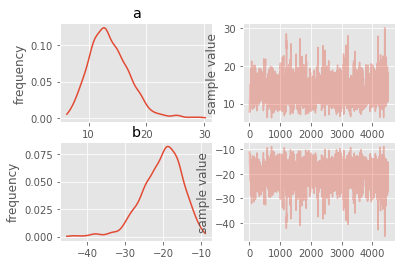

In [12]:
# 事後分布plot
# トレースプロットは横軸step縦軸サンプリングの値
# トレースプロットがまんべんなくplot（サンプリング）されているなら収束してる

fig = fit.plot()

In [13]:
# ベイズ信頼区間を出すためにパラメータの値抽出

ms_a = fit.extract("a")["a"]
ms_b = fit.extract("b")["b"]

In [14]:
# 抽出したパラメータでロジスティックス関数何本も書く

x = np.arange(1.0, 2.0, 0.01)
f = lambda x : 1.0 / (1.0 + np.exp(-x))  # ロジスティックス関数
df_b = pd.DataFrame([])
for i in range(x.shape[0]):
    df_b[i] = f(ms_a * x[i] + ms_b)

In [15]:
df_b.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.023472,0.025449,0.027587,0.029899,0.032399,0.035101,0.038018,0.041168,0.044567,0.048232,...,0.976588,0.978410,0.980093,0.981647,0.983082,0.984407,0.985629,0.986757,0.987797,0.988757
1,0.005514,0.006176,0.006917,0.007747,0.008675,0.009713,0.010874,0.012172,0.013623,0.015245,...,0.993778,0.994445,0.995041,0.995573,0.996049,0.996473,0.996852,0.997191,0.997493,0.997763
2,0.001787,0.002087,0.002437,0.002846,0.003324,0.003882,0.004532,0.005291,0.006176,0.007209,...,0.999538,0.999604,0.999661,0.999710,0.999752,0.999788,0.999818,0.999844,0.999867,0.999886
3,0.004785,0.005350,0.005983,0.006689,0.007478,0.008360,0.009344,0.010443,0.011670,0.013039,...,0.991599,0.992485,0.993278,0.993988,0.994623,0.995192,0.995700,0.996155,0.996562,0.996926
4,0.000170,0.000202,0.000239,0.000284,0.000336,0.000398,0.000472,0.000560,0.000664,0.000787,...,0.998694,0.998898,0.999070,0.999216,0.999338,0.999442,0.999529,0.999603,0.999665,0.999717


In [16]:
# ベイズ信頼区間の上限下限

low_y50, high_y50 = mstats.mquantiles(df_b, [0.25, 0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025, 0.975], axis=0)

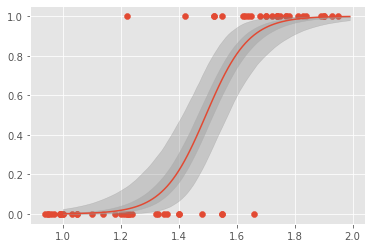

In [17]:
# ベイズ信頼区間含めて観測データplot

plt.scatter(df["log10 C"], df["death"])
plt.fill_between(x, low_y95, high_y95, alpha = 0.3, color = "gray")
plt.fill_between(x, low_y50, high_y50, alpha = 0.6, color = "darkgray")
plt.plot(x, f(a*x+b))